<a href="https://colab.research.google.com/github/urieliram/tc_uc/blob/main/Figures_TC_UC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
cm = 1/2.54

# GRÁFICOS DE CONVERGENCIA milp, milp2, hard3, harjk lbc, ks, 


## Lectura de archivos log

In [2]:
## Lectura de datos
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Log1.zip to Log1.zip
User uploaded file "Log1.zip" with length 125206 bytes


In [3]:
# !pip install unrar
# !unrar x "/content/Logs1.rar"

In [4]:
!unzip "Log1.zip" -d "/content"

Archive:  Log1.zip
  inflating: /content/Log_071.log    
  inflating: /content/Log_072.log    
  inflating: /content/logfileMilp2uc_072.log  
  inflating: /content/logfileMilp2uc_071.log  
  inflating: /content/Logs.txt       
  inflating: /content/logfileMilp2uc_065.log  
  inflating: /content/logfileMilp2uc_064.log  
  inflating: /content/logfileMilp2uc_063.log  
  inflating: /content/logfileMilp2uc_061.log  
  inflating: /content/Log_065.log    
  inflating: /content/Log_064.log    
  inflating: /content/Log_063.log    
  inflating: /content/Log_074.log    
  inflating: /content/logfileMilp2uc_074.log  
  inflating: /content/Log_061.log    
  inflating: /content/logfileMilp2uc_073.log  
  inflating: /content/Log_073.log    


In [5]:
def validateFiles():
  list=[]
  f = open("/content/Logs.txt","r")
  validFiles = [i.replace("\n","") for i in f]
  #print(validFiles)
  f.close()
  onlyfiles = [f.split(".")[0] for f in listdir("/content") if isfile(join("/content", f))]
  for i in validFiles:
    list.append(i)
    if i not in onlyfiles:
      return False
  return True, list
list=[]
if validateFiles() is False:
   print("!!! Faltan archivos")   
   temp, list = validateFiles()
   print(list)
else:
   temp, list = validateFiles()
   print("Archivos completos")
   

Archivos completos


## Extrae información de los logs

In [6]:
class ExtractCPLEX:

  def findPos(self,file,spected, starter = "Node  Left"):
    file = open(file,"r")
    for i,j in enumerate(file):
      if starter in j:
        return [(j.index(k)+len(k)-1) for k in spected]
  
  def getFilelog(self,f):
    with open(f, 'r') as file:
      data = file.read().replace('\n', '')
    tmp = []
    for i in re.findall(r"\w*Logfile\s*\'*[a-zA-z.+]*\'",data):
      tmp.append(i.replace("'","").split(" ")[1])
    return tmp

  def createTables(self,fn):
    table_start = False
    spected = ['Node', 'Left', 'Objective', 'IInf', 'Integer', 'Bound', 'ItCnt', 'Gap']
    expectedPositions = self.findPos(fn,spected)
    tables = {"seconds":[],"ticks":[],"solution":[],"Node":[],"Left":[],"Objective":[],"IInf":[],"Integer":[],"Bound":[],"ItCnt":[],"Gap":[],"cuts":[]}
    time = None
    ticks = None
    cuts = None
    f = open(fn,"r")    
    for i in f:
      if re.findall(r"\d{1,}[+]{1}\d{1,}",i):
        i = " ".join(i.split("+"))
      if("Cover cuts applied" in i or "Performing restart 1" in i):
        table_start = False
      if("Elapsed time" in i):
          tmp = [float(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
          time = tmp[0]
          ticks = tmp[1]
      if(table_start):        
        if((str(i)[0] == " " or str(i)[0] == "*") and str(i)[expectedPositions[0]].isdigit()):
          i = i.replace("uts: "," uts:")
          tables["seconds"].append(time)
          tables["ticks"].append(ticks)
          tables["solution"].append(1 if i[0]=="*" else 0)
          tables["cuts"].append(None)
          for j,m in zip(expectedPositions,spected):
            if i[j] != " ":
              tmp = ""
              for k in range(j,0,-1):
                if i[k] != " ":
                  tmp += i[k]
                else: 
                  break 
              tmp = tmp[::-1]
              if("ut" in tmp.lower() or "infeasible" in tmp.lower() or "integral" in tmp.lower()):
                if("uts" in tmp.lower()):
                  tables["cuts"][-1] = int(tmp.split(":")[1])
                tables[m].append(tables[m][-1])
              else:
                if m == "Gap":
                  tables[m].append(float(tmp)/100)
                else: 
                  tables[m].append(float(tmp))
            else:
              tables[m].append(None)
      if("Node  Left"):
        table_start = True

    return tables

  def extract(self,fn):
    variables = {"mipPresolveEliminated":[],"mipPresolveModified":[],"aggregatorDid":[],"reducedMipHasColumns":[],"reducedMipHasNonZero":[],"reducedMipHasBinaries":[],"reducedMipHasGeneral":[],"cliqueTableMembers":[],"rootRelaxSolSeconds":[],"rootRelaxSolTicks":[]}
    variables["logFile"] = self.getFilelog(fn)
    tables = self.createTables(fn)
    f = open(fn, "r")    
    for i in f:
      if("linear optimization" in i):
        variables["linearOpt"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("optimality gap tolerance" in i):
        variables["gapTol"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("time limit in seconds" in i):
        variables["timeLimit"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("emphasis for MIP optimization" in i):
        variables["mipOpt"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("Objective sense" in i):
        variables["objSense"] = i.replace(" ","").replace("\n","").split(":")[1]
      if("Variables" in i):
        if("Box:" in i):
          variablesValue = ["variablesValue","Nneg","Box","Binary"]
          for j,k in enumerate(re.findall(r'\d+', i.replace(" ","").replace("\n","").split(":",1)[1])):
            variables[variablesValue[j]] = float(k)
        else:
          variablesValue = ["minLB","maxUb"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
      if("Objective nonzeros" in i):
        if("Min" in i or "Max" in i):
          variablesValue = ["objNonZerosMin","objNonZerosMax"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          variables["objNonZeros"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("Linear constraints" in i):
        if("Less" in i):
          variablesValue = ["linearConstraintsValue","less","greater","equal"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          pass
      if("Nonzeros" in i):
        if("Min" in i):
          variablesValue = ["nonZerosMin","nonZerosMax"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          variables["nonZeros"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("RHS nonzeros" in i):
        if("Min" in i):
          variablesValue = ["rhsNonZerosMin","rhsNonZerosMax"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          variables["rhsNonZeros"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("CPXPARAM_TimeLimit" in i):
        variables["CPXPARAM_TimeLimit"] = float(i.replace("\n","").split(" ")[-1])
      if("MIP Presolve eliminated" in i):
        variables["mipPresolveEliminated"].append([int(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)])
      if("MIP Presolve modified " in i):
        variables["mipPresolveModified"].append(int(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)[0]))
      if("Reduced MIP has" in i):
        if("indicators." in i):
          tmp = [int(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
          variables["reducedMipHasBinaries"].append(tmp[0])
          variables["reducedMipHasGeneral"].append(tmp[1])
        else:
          tmp = [int(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
          variables["reducedMipHasColumns"].append(tmp[1])
          variables["reducedMipHasNonZero"].append(tmp[-1])
          reduceHasGeneral = []
      if("Clique" in i):
        variables["cliqueTableMembers"].append(float(i.replace(" ","").replace("\n","").split(":")[1]))
      if("Aggregator did" in i):
        variables["aggregatorDid"].append(int(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)[0]))
      if("Root relaxation" in i):
        tmp = [float(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
        variables["rootRelaxSolSeconds"].append(tmp[0])
        variables["rootRelaxSolTicks"].append(tmp[1])
      if("Lift and" in i):
        variables["liftAndProjectCuts"] = int(i.replace(" ","").replace("\n","").split(":")[1])
      if("Gomory fractional" in i):
        variables["gomoryFract"] = int(i.replace(" ","").replace("\n","").split(":")[1])

    df=pd.DataFrame.from_dict(tables).rename(columns={"seconds":"seconds","ticks":"ticks","solution":"solution","Node":"node","Left":"nodesLeft","Objective":"objective","IInf":"iinf","Integer":"bestInteger","Bound":"BestBound","ItCnt":"itCnt","Gap":"gap","cuts":"cuts"})
    df['seconds'] = df['seconds'].fillna(0)
    eps=np.arange(0, 1, 1/(len(df)), dtype=float)
    df['eps'] = eps
    sum_column = df["seconds"] + df["eps"]
    df["seconds"] = sum_column
    df['ticks'] = df['ticks'].fillna(0)
    eps=np.arange(0, 1, 1/(len(df)), dtype=float)
    df['eps'] = eps
    sum_column = df["ticks"] + df["eps"]
    df["ticks"] = sum_column
    return df,variables

In [7]:
class Extract:
  def __init__(self,log):
    self.log = log 
  def getFilelog(self,f):
    with open(f, 'r') as file:
      data = file.read().replace('\n', '')
    tmp = []
    for i in re.findall(r"\w*"+self.log+"\s*\'*[a-zA-z.+]*\'",data):
      print(i)
      tmp.append(i.replace("'","").split(" ")[1])
    return tmp
  def extract(self):
    fn= "/content/"+self.log+".log"
    variables = {}
    variables["logFile"] = self.log.replace("Log","uc")
    f = open(fn, "r")
    for i in f:
      # if("z_milp=" in i):
      #   variables["z_milp"]  = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("z_milp2=" in i):
        variables["z_milp2"] = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("z_harjk=" in i):
        variables["z_harjk"] = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("z_hard3=" in i):
        variables["z_hard3"] = float(i.replace(" ","").replace("\n","").split("=")[1])        
      # if("t_milp=" in i):
      #   variables["t_milp"]  = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("t_milp2=" in i):
        variables["t_milp2"] = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("t_harjk=" in i):
        variables["t_harjk"] = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("t_hard3=" in i):
        variables["t_hard3"] = float(i.replace(" ","").replace("\n","").split("=")[1])

    # variables["flag_milp" ] = False
    variables["flag_milp2"] = False
    variables["flag_harjk"] = False
    variables["flag_hard3"] = False

    # if variables["z_milp"]  != 1E+75:
    #   variables["flag_milp"] = True
    if variables["z_milp2"] != 1E+75:
      variables["flag_milp2"] = True
    if variables["z_harjk"] != 1E+75:
      variables["flag_harjk"] = True
    if variables["z_hard3"] != 1E+75:
      variables["flag_hard3"] = True

    start = ["lbc1 results","lbc2 results","lbc3 results","lbc4 results","KS results"]
    stop  = ["lbc1 end"    ,"lbc2 end"    ,"lbc3 end"    ,"lbc4 end"    ,"KS end"    ]
    for p in range(5):
      pattern_start = re.compile(r""+start[p])
      pattern_stop  = re.compile(r""+"^"+stop[p])
      i = 0
      extract_on = False
      extracts = []
      with open(r''+fn, 'rt') as myfile:
          for line in myfile:
              i += 1  # line counting starts with 1
              if pattern_start.match(line):
                  extract_on = True
              if pattern_stop.search(line):
                  extract_on = False
              if extract_on:
                  extracts.append((i, line.rstrip('\n')))
      listlines=[]; x=[]; y=[]
      for line in extracts:
        listlines.append(line[1])
      if len(listlines)!=0:
        del listlines[0]
      for i in listlines:
        if float(re.split(',',i.replace(" ",""))[1])!=1E+75:
          x.append(float(re.split(',',i.replace(" ",""))[0]))
          y.append(float(re.split(',',i.replace(" ",""))[1]))

      if p==0:
        variables["t_lbc1"] = x
        variables["z_lbc1"] = y
        variables["flag_lbc1"] = True
      if p==1:
        variables["t_lbc2"] = x
        variables["z_lbc2"] = y
        variables["flag_lbc2"] = True
      if p==2:
        variables["t_lbc3"] = x
        variables["z_lbc3"] = y
        variables["flag_lbc3"] = True
      if p==3:
        variables["t_lbc4"] = x
        variables["z_lbc4"] = y
        variables["flag_lbc4"] = True
      if p==4:
        variables["t_KS"] = x
        variables["z_KS"] = y
        variables["flag_KS"] = True

    return variables

ex         = Extract('Log_061')
variablesx = ex.extract()
print(variablesx)

{'logFile': 'uc_061', 't_hard3': 1214.8, 'z_hard3': 22348839.6, 't_harjk': 1214.9, 'z_harjk': 22358438.4, 't_milp2': 7234.4, 'z_milp2': 22342342.0, 'flag_milp2': True, 'flag_harjk': True, 'flag_hard3': True, 't_lbc1': [1214.7881741523743, 1330.7, 2547.9, 3765.2, 4982.9, 7219.9], 'z_lbc1': [22348839.580970775, 22348839.580970775, 22343549.107091032, 22342341.971034825, 22342341.971034776, 22342341.971034776], 'flag_lbc1': True, 't_lbc2': [1214.7881741523743, 1332.9, 2551.1, 3769.4, 4987.8, 7220.3], 'z_lbc2': [22348839.580970775, 22348839.580970775, 22344609.107091248, 22342341.971034836, 22342341.97103478, 22342341.97103478], 'flag_lbc2': True, 't_lbc3': [1214.7881741523743, 1332.9, 2551.3, 3769.5, 4987.9, 7220.2], 'z_lbc3': [22348839.580970775, 22348839.580970775, 22347152.112599537, 22346065.36259932, 22346065.36259877, 22345005.362600006], 'flag_lbc3': True, 't_lbc4': [1214.7881741523743, 1352.5, 2569.4, 3788.4, 5007.4, 7219.2], 'z_lbc4': [22348839.580970775, 22348839.580970775, 2234

## Despliega gráficas

In [8]:
## Test ExtractCPLEX
#e = ExtractCPLEX()
#df, dic = e.extract("/content/logfileMilp2uc_061.log")
#df.plot.line( x='seconds',y='bestInteger',style='o-',label='_nolegend_')

In [9]:
def graficas(title='',graphs=[]):
  plt.figure()
  models = ['MILP2','Harjk','Harduc','LB1','LB2','LB3','LB4','KS']
  i=0
  for tup in graphs:
      x    = tup[0]
      y    = tup[1]
      if tup[2]:
        if i==0:
          plt.plot(x, y, 'x',  label = models[i],markersize=7,color='magenta')
        else:
          plt.plot(x, y, '.-', label = models[i],markersize=7,)
      i=i+1

  if title !='uc_063':
    if title !='uc_064':
      if title !='uc_065':
        e = ExtractCPLEX()
        df, dic = e.extract("/content/logfileMilp2"+title+".log")
        a = df['seconds'].values.tolist()
        ar = np.array(a)
        ar = ar + 1200 ##Agregamos los segundos de Harduc
        plt.plot( ar,df['bestInteger'].values.tolist(),'x',color='magenta')

  plt.xlabel("Time (seconds)")
  plt.ylabel("z ($)")
  plt.title('Instance '+title)
  plt.legend(bbox_to_anchor=(1, 0.75))
  plt.tight_layout()
  plt.savefig('fig:'+title+'.pdf')
  # plt.show()
  return 0

In [ ]:
for item in list:
    list2  = []
    graphs = []
    try:
      e = Extract(item)
      variables = e.extract()
      if True:
        variables["flag_harjk"] = False
        # graphs.append(([variables['t_milp' ]],[variables['z_milp']] ,variables["flag_milp"]))
        graphs.append(([variables['t_milp2']],[variables['z_milp2']],variables["flag_milp2"]))
        graphs.append(([variables['t_harjk']],[variables['z_harjk']],variables["flag_harjk"]))
        graphs.append(([variables['t_hard3']],[variables['z_hard3']],variables["flag_hard3"]))
        graphs.append((variables['t_lbc1' ],variables['z_lbc1' ],variables["flag_lbc1"]))
        graphs.append((variables['t_lbc2' ],variables['z_lbc2' ],variables["flag_lbc2"]))
        graphs.append((variables['t_lbc3' ],variables['z_lbc3' ],variables["flag_lbc3"]))
        graphs.append((variables['t_lbc4' ],variables['z_lbc4' ],variables["flag_lbc4"]))
        graphs.append((variables['t_KS' ],variables['z_KS' ],variables["flag_KS"]))
        graficas(title=variables["logFile"],graphs=graphs)
      list2.append(variables)
    except Exception as err:
      print("Fail in ", item+".log"+ " file")
      print(str(err))

# GRAFICOS DE BOXPLOT


In [11]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path = 'https://drive.google.com/uc?export=download&id=' 
URL  = 'https://drive.google.com/file/d/1ySF5y3FdEZrEAu1jZ_P1PdBJSk64TQvt/view?usp=share_link'
df   = pd.read_csv(path+URL.split('/')[-2],header=0)
                #  dtype={'SERIE11':float,'SERIE12':float,'SERIE13':float,'SERIE14':float,'SERIE15':float,'SERIE16':float,'SERIE17':float})
#names=['MILP','FP','Harjk','Hard','LB1','LB2','LB3','KS']
#dtype={'MEM1':float,'MEM2':float,'MEM3':float,'MEM4':float}

##      z_milp	z_feas	z_harjk	 z_hard3	z_lbc1	z_lbc2	z_lbc3	z_ks    (09-16)
##    	t_milp	t_feas	t_harjk  t_hard3	t_lbc1	t_lbc2	t_lbc3	t_ks    (18-26)
##      g_milp	g_feas	g_harjk	 g_hard3	g_lbc1	g_lbc2	g_lbc3	g_ks    (28-35)
df.dropna(inplace=True)

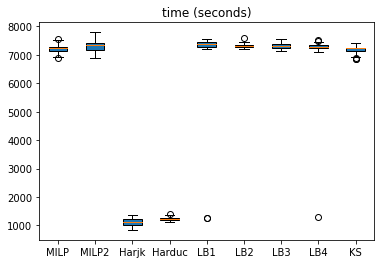

In [12]:
##Imprimir TIME
data1  = df.t_milp.to_numpy()
data2  = df.t_milp2.to_numpy()
data3  = df.t_harjk.to_numpy()
data4  = df.t_hard3.to_numpy()
data5  = df.t_lbc1.to_numpy()
data6  = df.t_lbc2.to_numpy()
data7  = df.t_lbc3.to_numpy()
data8  = df.t_lbc4.to_numpy()
data9  = df.t_ks.to_numpy()
labels = ['MILP','MILP2','Harjk','Harduc','LB1','LB2','LB3','LB4','KS']
x=[data1,data2,data3,data4,data5,data6,data7,data8,data9]
fig,ax = plt.subplots()
ax.set_title('time (seconds)')
bp = ax.boxplot(x,           
positions=[1,2,3,4,5,6,7,8,9],      # where to put these arrays
labels = labels, patch_artist=True)  # allow filling the box with colors
# ax.legend()
namefile = 'fig:boxplottime'+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

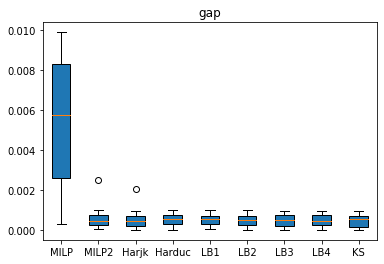

In [13]:
##Imprimir GAP
data1  = df.g_milp.to_numpy()
data2  = df.g_milp2.to_numpy()
data3  = df.g_harjk.to_numpy()
data4  = df.g_hard3.to_numpy()
data5  = df.g_lbc1.to_numpy()
data6  = df.g_lbc2.to_numpy()
data7  = df.g_lbc3.to_numpy()
data8  = df.g_lbc4.to_numpy()
data9  = df.g_ks.to_numpy()
labels = ['MILP','MILP2','Harjk','Harduc','LB1','LB2','LB3','LB4','KS']
x=[data1,data2,data3,data4,data5,data6,data7,data8,data9]
fig,ax = plt.subplots()
ax.set_title('gap')
bp = ax.boxplot(x,           
positions=[1,2,3,4,5,6,7,8,9],      # where to put these arrays
labels = labels, patch_artist=True)  # allow filling the box with colors
# ax.legend()
namefile = 'fig:boxplotgap'+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

## Análisis estadístico

In [14]:
# Import libraries
from scipy import stats

# Conduct the Kruskal-Wallis Test
result = stats.kruskal(data2,data5,data6,data7,data8,data9)

# Print the result
print(result)

KruskalResult(statistic=2.1300269168016257, pvalue=0.8308765529861137)


Kruskal-Wallis test discussion:  In this example, the test statistic comes out to be equal to 87 and the corresponding p-value is 2.1856E-17. 

(As the p-value is not less than 0.05, we cannot reject the null hypothesis that the median of optimality gap is the same for all groups. Hence, We don’t have sufficient proof to claim that the different types of methods used to lead to statistically significant differences in the acuracy of methods.)

(As the p-value is less than 0.05, we reject the null hypothesis that the median of optimality gap is the same for all groups. Hence, We don’t have sufficient proof to reject that the different types of methods used to lead to statistically significant differences in the acuracy of methods.)

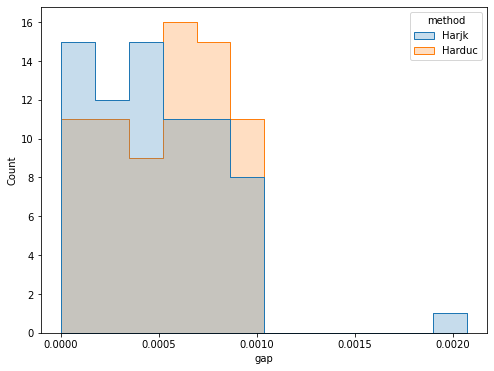

In [15]:
## https://www.geeksforgeeks.org/data-visualization-with-python-seaborn/
import seaborn as sns
# penguins = sns.load_dataset("penguins")
# print(penguins)
# sns.histplot(penguins, x="flipper_length_mm", hue="species", element="step")

fig, ax = plt.subplots(figsize=(8, 6))
method  = ['Harjk' ]*(len(data3))
method2 = ['Harduc']*(len(data4))
method  = method + method2
data = np.concatenate((data3, data4), axis=0)
# initialise data of lists.
data = {'gap'       :data,
        'method'  :method
        }
  
df1 = pd.DataFrame( data )
sns.histplot(df1, x="gap", hue="method", element="step")

# sns.distplot(df1, x="z", hist=True, kde=True, hist_kws={'edgecolor': 'black'}, kde_kws={'linewidth': 2}, bins=10,
#              color='green')

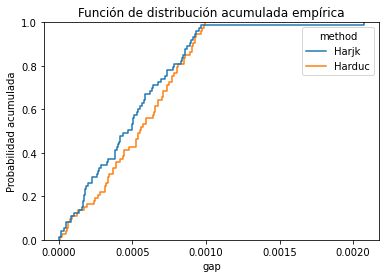

In [16]:
## https://www.cienciadedatos.net/documentos/pystats08-comparacion-distribuciones-test-kolmogorov-smirnov-python.html
# Representación gráfica de las curvas ecdf
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
sns.ecdfplot(data=df1, x='gap', hue='method', ax=ax)
ax.set_title("Función de distribución acumulada empírica")
ax.set_ylabel("Probabilidad acumulada");

In [20]:
# Modelado y test estadísticos
# ==============================================================================
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import ks_2samp
# Ajuste de las funciones ecdf con cada muestra
# ==============================================================================
ecdf_harjk  = ECDF(df1.loc[df1.method == 'Harjk' , 'gap'])
ecdf_harduc = ECDF(df1.loc[df1.method == 'Harduc', 'gap'])
# Estimación de la probabilidad acumulada de cada valor de salario observado
# ==============================================================================
grid_gap = np.sort(df1.gap.unique())
prob_acumulada_ecdf_harjk  = ecdf_harjk( grid_gap)
prob_acumulada_ecdf_harduc = ecdf_harduc(grid_gap)
# Distancia Kolmogorov–Smirnov
# ==============================================================================
abs_dif = np.abs(prob_acumulada_ecdf_harjk - prob_acumulada_ecdf_harduc)
distancia_ks = np.max(abs_dif)
print(f"Distancia Kolmogorov–Smirnov: {distancia_ks :.4f}")

Distancia Kolmogorov–Smirnov: 0.1507


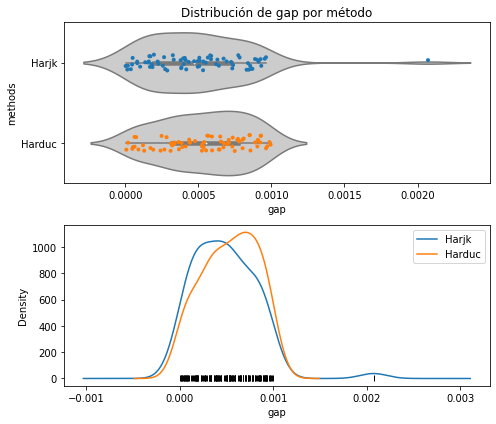

In [21]:
if True:
  # Modelado y test estadísticos Kolmogorov–Smirnov
  # ============================================================================
  from statsmodels.distributions.empirical_distribution import ECDF
  from scipy.stats import ks_2samp
  # Gráficos distribución observada 
  # ============================================================================
  import matplotlib.pyplot as plt
  %matplotlib inline
  # plt.style.use('fivethirtyeight')
  import seaborn as sns
  fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 6))
  sns.violinplot(
      x       = df1.gap,
      y       = df1.method,
      color   = '.8',
      ax      = axs[0]
  )
  sns.stripplot(
      x       = df1.gap,
      y       = df1.method,
      data    = df1,
      size    = 4,
      jitter  = 0.1,
      ax      = axs[0]
  )
  axs[0].set_title('Distribución de gap por método')
  axs[0].set_ylabel('methods')
  axs[0].set_xlabel('gap');

  for i in df1.method.unique():
      datos_temp = df1[df1.method == i]['gap']
      datos_temp.plot.kde(ax=axs[1], label=i)
      axs[1].plot(datos_temp, np.full_like(datos_temp, 0), '|k', markeredgewidth=1)

  axs[1].set_xlabel('gap');
  axs[1].legend()

  fig.tight_layout();

## Ejemplo boxplot

In [ ]:

#https://towardsdatascience.com/making-publication-quality-figures-in-python-part-iii-box-plot-bar-plot-scatter-plot-407fa457449
# prepare some data
np.random.seed(42)
data1 = np.random.randn(100)
data2 = np.random.randn(100)
data3 = np.random.randn(100)
data4 = np.random.randn(100)

fig,ax = plt.subplots()
bp = ax.boxplot(x=[data1,data2,data3,data4],  # sequence of arrays
positions=[1,2,3,4],   # where to put these arrays
patch_artist=True)  # allow filling the box with colors
# ax.legend()
namefile = 'boxplot_'+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()